## Topological Compression

`transpile_and_compress` selects topologically most important qubits of a backend
to produce limited coupling map - to decrease transpilation and simulation time:

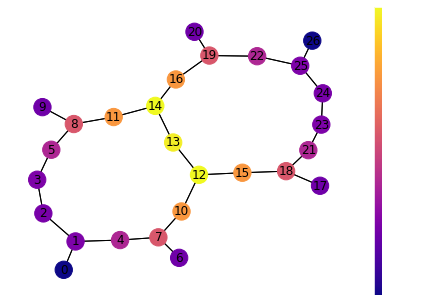

We use flexible measure of node importance - node “closeness centrality” in backend topology graph.

Closeness centrality is efficiently calculated using “rustworkx” graph library function:

https://qiskit.org/ecosystem/rustworkx/dev/apiref/rustworkx.closeness_centrality.html

Flexible measure of node importance can be expanded with other metrics -
for example, neighbors counts or qubit noise levels.

Once importances are calculated - we traverse topology graph using A-star search -
starting from the most important node.

Traversed nodes are added to limited qubit list - which forms a connected subgraph.

Discovered subgraph is used to limit backend topology during transpilation.

### Imports

In [1]:
from rustworkx import spring_layout
from rustworkx import closeness_centrality
from rustworkx.visualization import mpl_draw

import qiskit

from qiskit.providers.aer import AerSimulator

from qiskit.providers.fake_provider import FakeBackend5QV2
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeMontrealV2
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.providers.fake_provider import FakeBoeblingenV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from matplotlib import pyplot as plt

plt.style.use("dark_background")

%cd ../..

from rivet_transpiler import transpile
from rivet_transpiler import get_full_map
from rivet_transpiler import get_litmus_circuit
from rivet_transpiler import get_limited_coupling_list

from rivet_transpiler import get_used_qubit_indices
from rivet_transpiler import transpile_and_compress

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler


### Backend

In [2]:
# FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
FAKE_BACKEND = FakeMontrealV2()

backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

# backend.options.noise_model = None

# backend = AerSimulator()

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Circuit

In [3]:
QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

litmus_circuit.draw(fold=-1)

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

### Transpile

In [4]:
transpiled_litmus_circuit = transpile(
    litmus_circuit, 
    backend,
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234,
)

transpiled_litmus_circuit.draw(idle_wires=False, fold=-1)

┌───┐                          ░ 
 ancilla_13 -> 5 ───────■────────┤ X ├──■───────────────────────░─
                      ┌─┴─┐      └─┬─┘┌─┴─┐                     ░ 
 ancilla_14 -> 8 ─────┤ X ├────────■──┤ X ├─────────────────────░─
                 ┌────┴───┴─────┐┌───┐└───┘                     ░ 
Litmus_0_1 -> 11 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░─
                 ├──────────────┤└─┬─┘┌───┐     ┌───┐  │  ┌───┐ ░ 
Litmus_0_2 -> 13 ┤ Rz(Litmus_2) ├──┼──┤ X ├──■──┤ X ├──┼──┤ X ├─░─
                 ├──────────────┤  │  └─┬─┘┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘ ░ 
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■────■──┤ X ├──■──┤ X ├──■───░─
                 └──────────────┘          └───┘     └───┘      ░

### Transpile and Compress

In [5]:
compressed_litmus_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=backend,
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234,
)

compressed_litmus_circuit.draw(idle_wires=False, fold=-1)

┌──────────────┐          ┌───┐          ┌───┐ ░  ░ 
Litmus_0_2 -> 12 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░──░─
                 ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░  ░ 
Litmus_0_0 -> 13 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░────
                 ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░  ░ 
Litmus_0_1 -> 14 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░──░─
                 └──────────────┘└───┘                          ░  ░

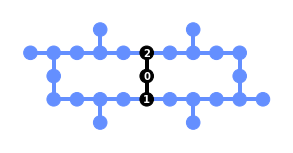

In [6]:
qiskit.visualization.plot_circuit_layout(compressed_litmus_circuit, FAKE_BACKEND)

### Custom Coupling Map

In [7]:
# Custom Coupling List

coupling_map = backend.configuration().coupling_map

coupling_list = [list(pair) for pair in coupling_map]

# Remove edge between qubits 12 and 13:

coupling_list.remove([12, 13])
coupling_list.remove([13, 12])

coupling_map = qiskit.transpiler.CouplingMap(couplinglist=coupling_list)

# coupling_map

In [8]:
compressed_litmus_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=backend,
    coupling_map=coupling_map,
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234,
)

compressed_litmus_circuit.draw(idle_wires=False, fold=-1)

┌──────────────┐          ┌───┐          ┌───┐ ░  ░ 
Litmus_0_2 -> 11 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░──░─
                 ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░  ░ 
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░────
                 ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░  ░ 
Litmus_0_1 -> 16 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■────────░──░─
                 └──────────────┘└───┘                          ░  ░

In [9]:
# Backend None)

compressed_litmus_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=None,
    coupling_map=coupling_map,
    optimization_level=3,
    routing_method='lookahead',
    seed_transpiler=1234,
)

compressed_litmus_circuit.draw(idle_wires=False, fold=-1)

┌──────────────┐             ┌───┐ ░  ░ 
Litmus_0_2 -> 11 ┤ Rz(Litmus_2) ├──────X──────┤ X ├─░──░─
                 ├──────────────┤      │ ┌───┐└─┬─┘ ░  ░ 
Litmus_0_0 -> 14 ┤ Rz(Litmus_0) ├──■───X─┤ X ├──■───░────
                 ├──────────────┤┌─┴─┐   └─┬─┘      ░  ░ 
Litmus_0_1 -> 16 ┤ Rz(Litmus_1) ├┤ X ├─────■────────░──░─
                 └──────────────┘└───┘              ░  ░

### No Topology Warning

In [10]:
compressed_litmus_circuit = transpile_and_compress(
    litmus_circuit, 
    backend=None,
    seed_transpiler=1234,
)

compressed_litmus_circuit.draw(idle_wires=False, fold=-1)

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler/rivet_transpiler/topological_compression.py:229: UserWarning: Provided Backend has no topology - no compression performed
  warnings.warn("Provided Backend has no topology - no compression performed")


┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

### Plot Backend Importances

In [11]:
def get_backend_importances_figure(backend, layout_seed=3):
    
    coupling_list = backend.configuration().coupling_map

    coupling_map = qiskit.transpiler.CouplingMap(couplinglist=coupling_list)
    
    graph = coupling_map.graph.to_undirected()
    
    positions = spring_layout(graph, seed=layout_seed)

    centralities = closeness_centrality(graph)

    importances = list(centralities.values())

    mpl_draw(graph,
             cmap="plasma",
             pos=positions,
             with_labels=True,
             node_color=importances)

    normalizer = plt.Normalize(vmin=min(importances), 
                               vmax=max(importances))

    scalar_mappable = plt.cm.ScalarMappable(cmap="plasma", norm=normalizer)

    colorbar = plt.colorbar(scalar_mappable, aspect=40)

    colorbar.ax.get_yaxis().labelpad = 15
    colorbar.ax.set_ylabel('Centrality', rotation=270)
    
    figure = plt.gcf()
    
    figure.patch.set_facecolor('white')
    figure.patch.set_alpha(0.05)
    
    plt.close()

    return figure

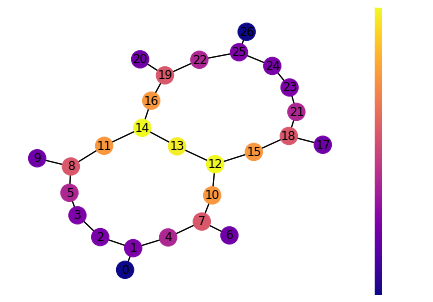

In [12]:
get_backend_importances_figure(backend)